# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

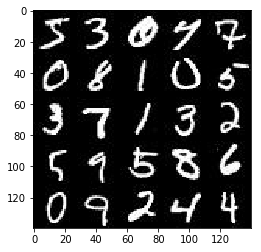

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

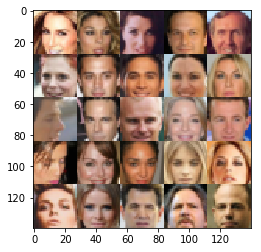

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :param alpha: Leaky ReLU factor (additionally added)
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):       
        # Image size is 28x28x3
        x1 = tf.layers.conv2d(images, filters=64, kernel_size=5, strides=2, padding='same')
        x1 = tf.maximum(x1, x1 * alpha)
        
        # Image size is 14x14x64
        x2 = tf.layers.conv2d(x1, filters=128, kernel_size=5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(x2, x2 * alpha)
        
        # Image size is 8x8x128
        x3 = tf.layers.conv2d(x2, filters=256, kernel_size=5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(x3, x3 * alpha)
        
        flat = tf.reshape(x3, (-1, 8*8*128))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :param alpha: Leaky ReLU (added)
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*512, activation=None) 
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(x1, x1 * alpha)
        # 7x7x256
        
        x2 = tf.layers.conv2d_transpose(x1, filters=256, kernel_size=5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(x2, x2 * alpha)
        # 14x14x256
        
        x3 = tf.layers.conv2d_transpose(x2, filters=128, kernel_size=5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(x3, x3 * alpha)
        # 28x28x128
        
        # Output layer 
        logits = tf.layers.conv2d_transpose(x3, filters=out_channel_dim, kernel_size=5, strides=1, padding='same')
        # 28 x 28 x outchannel_dim
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [20]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    # TODO: Build Model with previous functions
    
    # Reset everything
    #tf.reset_default_graph()
    
    # Generate model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3]) #mimic input channels
    d_train_opt, g_train_opt= model_opt(d_loss, g_loss, learning_rate, beta1)
    
    # Verbose variable
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps +=1
                
                # Scale images
                batch_images *=2
                
                # Sample random noise for generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run Optimizzzzzzzers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate}) # needs images?
                
                # Verbose output
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % 50 == 0:
                    show_generator_output(sess, 20, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0000... Generator Loss: 16.8912
Epoch 1/2... Discriminator Loss: 0.4772... Generator Loss: 3.4583
Epoch 1/2... Discriminator Loss: 0.0452... Generator Loss: 4.2820
Epoch 1/2... Discriminator Loss: 3.0529... Generator Loss: 9.4541
Epoch 1/2... Discriminator Loss: 0.7306... Generator Loss: 1.5460


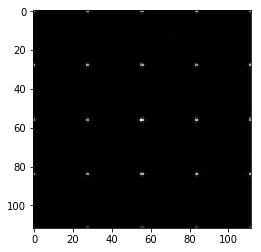

Epoch 1/2... Discriminator Loss: 0.6283... Generator Loss: 1.8861
Epoch 1/2... Discriminator Loss: 0.7804... Generator Loss: 1.2654
Epoch 1/2... Discriminator Loss: 0.5258... Generator Loss: 2.4139
Epoch 1/2... Discriminator Loss: 1.0435... Generator Loss: 2.1608
Epoch 1/2... Discriminator Loss: 1.4130... Generator Loss: 2.3385


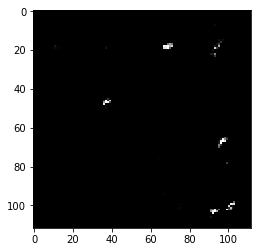

Epoch 1/2... Discriminator Loss: 0.8539... Generator Loss: 0.8885
Epoch 1/2... Discriminator Loss: 1.1588... Generator Loss: 3.3296
Epoch 1/2... Discriminator Loss: 1.1910... Generator Loss: 1.8184
Epoch 1/2... Discriminator Loss: 0.8555... Generator Loss: 1.2215
Epoch 1/2... Discriminator Loss: 0.7003... Generator Loss: 4.0833


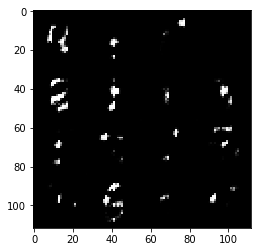

Epoch 1/2... Discriminator Loss: 1.2037... Generator Loss: 0.5640
Epoch 1/2... Discriminator Loss: 1.5621... Generator Loss: 0.3687
Epoch 1/2... Discriminator Loss: 0.7187... Generator Loss: 1.0833
Epoch 1/2... Discriminator Loss: 2.2626... Generator Loss: 0.1727
Epoch 1/2... Discriminator Loss: 1.1878... Generator Loss: 4.0164


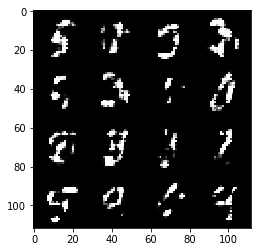

Epoch 1/2... Discriminator Loss: 0.7278... Generator Loss: 1.0544
Epoch 1/2... Discriminator Loss: 0.5003... Generator Loss: 2.1708
Epoch 1/2... Discriminator Loss: 1.4473... Generator Loss: 0.3933
Epoch 1/2... Discriminator Loss: 2.2494... Generator Loss: 5.5651
Epoch 1/2... Discriminator Loss: 0.7693... Generator Loss: 1.6715


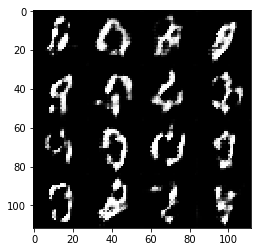

Epoch 1/2... Discriminator Loss: 0.4390... Generator Loss: 2.2205
Epoch 1/2... Discriminator Loss: 0.7769... Generator Loss: 1.0847
Epoch 1/2... Discriminator Loss: 0.7755... Generator Loss: 1.3217
Epoch 1/2... Discriminator Loss: 0.7324... Generator Loss: 1.0669
Epoch 1/2... Discriminator Loss: 1.0025... Generator Loss: 1.0366


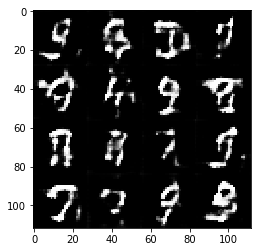

Epoch 1/2... Discriminator Loss: 1.4006... Generator Loss: 0.4162
Epoch 1/2... Discriminator Loss: 0.8544... Generator Loss: 1.4748
Epoch 1/2... Discriminator Loss: 0.8937... Generator Loss: 1.4972
Epoch 1/2... Discriminator Loss: 0.8808... Generator Loss: 1.6272
Epoch 1/2... Discriminator Loss: 0.9893... Generator Loss: 2.3474


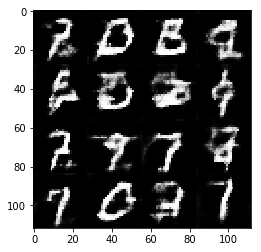

Epoch 1/2... Discriminator Loss: 1.1607... Generator Loss: 1.0777
Epoch 1/2... Discriminator Loss: 1.1720... Generator Loss: 1.0748
Epoch 1/2... Discriminator Loss: 0.7672... Generator Loss: 1.3348
Epoch 1/2... Discriminator Loss: 1.1575... Generator Loss: 1.8852
Epoch 1/2... Discriminator Loss: 1.1825... Generator Loss: 0.7205


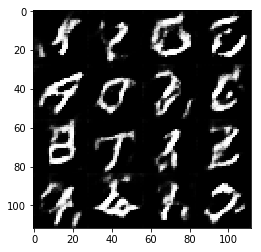

Epoch 1/2... Discriminator Loss: 1.4390... Generator Loss: 0.3662
Epoch 1/2... Discriminator Loss: 1.0696... Generator Loss: 0.6729
Epoch 1/2... Discriminator Loss: 0.9199... Generator Loss: 1.0905
Epoch 1/2... Discriminator Loss: 1.1641... Generator Loss: 0.6717
Epoch 1/2... Discriminator Loss: 0.7973... Generator Loss: 1.1522


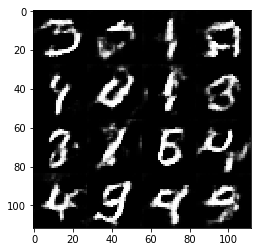

Epoch 1/2... Discriminator Loss: 0.9035... Generator Loss: 1.1527
Epoch 1/2... Discriminator Loss: 0.9216... Generator Loss: 0.9013
Epoch 1/2... Discriminator Loss: 0.8128... Generator Loss: 1.3518
Epoch 1/2... Discriminator Loss: 1.0270... Generator Loss: 0.9970
Epoch 1/2... Discriminator Loss: 1.5558... Generator Loss: 0.3465


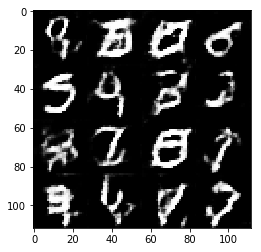

Epoch 1/2... Discriminator Loss: 1.3767... Generator Loss: 0.3710
Epoch 1/2... Discriminator Loss: 1.0246... Generator Loss: 0.7956
Epoch 1/2... Discriminator Loss: 1.4856... Generator Loss: 2.7191
Epoch 1/2... Discriminator Loss: 1.2215... Generator Loss: 0.5201
Epoch 1/2... Discriminator Loss: 1.1502... Generator Loss: 2.2062


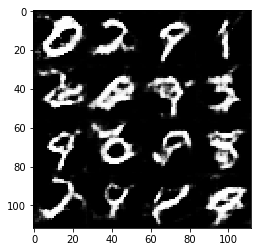

Epoch 1/2... Discriminator Loss: 0.9873... Generator Loss: 1.0800
Epoch 1/2... Discriminator Loss: 2.1239... Generator Loss: 0.1697
Epoch 1/2... Discriminator Loss: 0.7867... Generator Loss: 1.1152
Epoch 1/2... Discriminator Loss: 1.0532... Generator Loss: 0.7207
Epoch 1/2... Discriminator Loss: 0.9856... Generator Loss: 1.2622


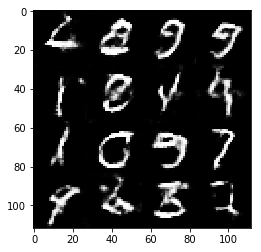

Epoch 1/2... Discriminator Loss: 0.9772... Generator Loss: 1.2884
Epoch 1/2... Discriminator Loss: 1.7166... Generator Loss: 0.3253
Epoch 1/2... Discriminator Loss: 1.1038... Generator Loss: 1.3181
Epoch 1/2... Discriminator Loss: 1.0813... Generator Loss: 0.6906
Epoch 1/2... Discriminator Loss: 1.2846... Generator Loss: 0.4678


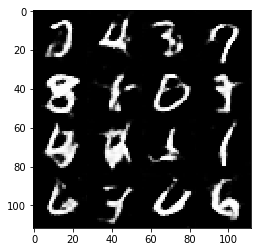

Epoch 1/2... Discriminator Loss: 1.1058... Generator Loss: 0.6178
Epoch 1/2... Discriminator Loss: 1.2302... Generator Loss: 0.4692
Epoch 1/2... Discriminator Loss: 1.5999... Generator Loss: 0.4193
Epoch 1/2... Discriminator Loss: 1.1069... Generator Loss: 0.6226
Epoch 1/2... Discriminator Loss: 1.5612... Generator Loss: 0.3184


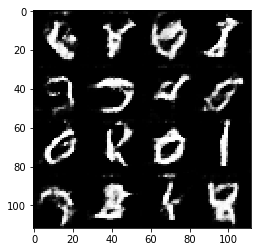

Epoch 1/2... Discriminator Loss: 1.4826... Generator Loss: 0.3363
Epoch 1/2... Discriminator Loss: 1.5314... Generator Loss: 0.3357
Epoch 1/2... Discriminator Loss: 0.9219... Generator Loss: 1.3996
Epoch 1/2... Discriminator Loss: 0.7191... Generator Loss: 1.7271
Epoch 1/2... Discriminator Loss: 1.9713... Generator Loss: 0.2093


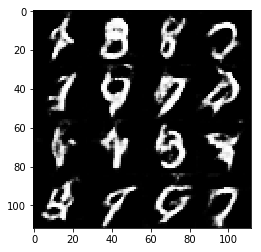

Epoch 1/2... Discriminator Loss: 1.0416... Generator Loss: 0.6174
Epoch 1/2... Discriminator Loss: 1.0437... Generator Loss: 1.5074
Epoch 1/2... Discriminator Loss: 2.3643... Generator Loss: 0.1315
Epoch 1/2... Discriminator Loss: 1.2407... Generator Loss: 0.7343
Epoch 1/2... Discriminator Loss: 1.0716... Generator Loss: 0.6884


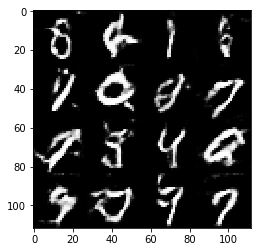

Epoch 1/2... Discriminator Loss: 1.0911... Generator Loss: 1.2507
Epoch 1/2... Discriminator Loss: 0.8450... Generator Loss: 1.0473
Epoch 1/2... Discriminator Loss: 0.9933... Generator Loss: 0.9658
Epoch 1/2... Discriminator Loss: 0.8987... Generator Loss: 0.8418
Epoch 1/2... Discriminator Loss: 0.7489... Generator Loss: 1.1882


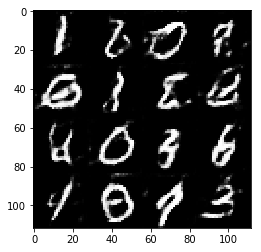

Epoch 1/2... Discriminator Loss: 2.1281... Generator Loss: 0.2484
Epoch 1/2... Discriminator Loss: 1.5152... Generator Loss: 1.4239
Epoch 1/2... Discriminator Loss: 0.8678... Generator Loss: 1.2947
Epoch 1/2... Discriminator Loss: 0.7479... Generator Loss: 1.0529
Epoch 1/2... Discriminator Loss: 1.0591... Generator Loss: 0.6838


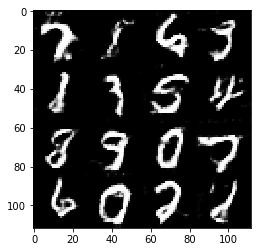

Epoch 1/2... Discriminator Loss: 1.4325... Generator Loss: 0.3748
Epoch 1/2... Discriminator Loss: 0.9447... Generator Loss: 1.8005
Epoch 1/2... Discriminator Loss: 0.9913... Generator Loss: 0.7218
Epoch 2/2... Discriminator Loss: 1.1804... Generator Loss: 0.5079
Epoch 2/2... Discriminator Loss: 0.9739... Generator Loss: 1.0286


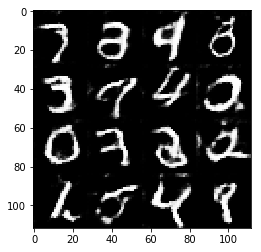

Epoch 2/2... Discriminator Loss: 1.2353... Generator Loss: 0.5366
Epoch 2/2... Discriminator Loss: 1.4375... Generator Loss: 0.3572
Epoch 2/2... Discriminator Loss: 1.3223... Generator Loss: 0.4453
Epoch 2/2... Discriminator Loss: 1.5916... Generator Loss: 0.3410
Epoch 2/2... Discriminator Loss: 0.9953... Generator Loss: 0.8562


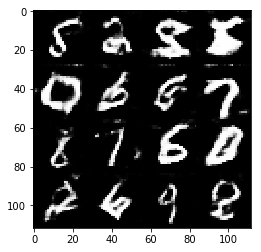

Epoch 2/2... Discriminator Loss: 1.2772... Generator Loss: 0.6223
Epoch 2/2... Discriminator Loss: 0.7621... Generator Loss: 1.3825
Epoch 2/2... Discriminator Loss: 0.7288... Generator Loss: 1.2453
Epoch 2/2... Discriminator Loss: 1.2016... Generator Loss: 0.6622
Epoch 2/2... Discriminator Loss: 1.1848... Generator Loss: 0.5708


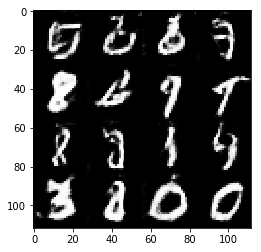

Epoch 2/2... Discriminator Loss: 1.2285... Generator Loss: 0.5001
Epoch 2/2... Discriminator Loss: 1.3937... Generator Loss: 0.3747
Epoch 2/2... Discriminator Loss: 1.4912... Generator Loss: 0.3615
Epoch 2/2... Discriminator Loss: 0.7534... Generator Loss: 1.1638
Epoch 2/2... Discriminator Loss: 1.0360... Generator Loss: 1.7409


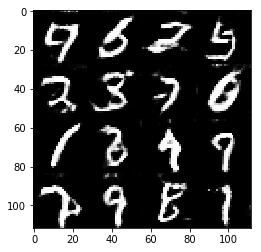

Epoch 2/2... Discriminator Loss: 0.6371... Generator Loss: 1.5879
Epoch 2/2... Discriminator Loss: 0.9982... Generator Loss: 0.6860
Epoch 2/2... Discriminator Loss: 0.6481... Generator Loss: 1.8118
Epoch 2/2... Discriminator Loss: 1.4198... Generator Loss: 2.5835
Epoch 2/2... Discriminator Loss: 1.7158... Generator Loss: 0.2812


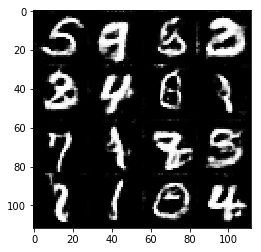

Epoch 2/2... Discriminator Loss: 1.5700... Generator Loss: 2.6202
Epoch 2/2... Discriminator Loss: 0.8897... Generator Loss: 1.0423
Epoch 2/2... Discriminator Loss: 1.1961... Generator Loss: 0.5064
Epoch 2/2... Discriminator Loss: 0.9990... Generator Loss: 0.8015
Epoch 2/2... Discriminator Loss: 1.1171... Generator Loss: 0.6487


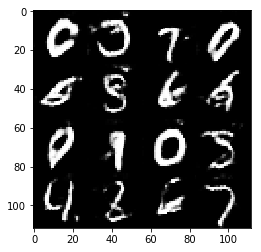

Epoch 2/2... Discriminator Loss: 0.7747... Generator Loss: 1.1835
Epoch 2/2... Discriminator Loss: 3.5423... Generator Loss: 4.7502
Epoch 2/2... Discriminator Loss: 1.1022... Generator Loss: 0.6105
Epoch 2/2... Discriminator Loss: 0.8364... Generator Loss: 0.9926
Epoch 2/2... Discriminator Loss: 1.0216... Generator Loss: 1.1582


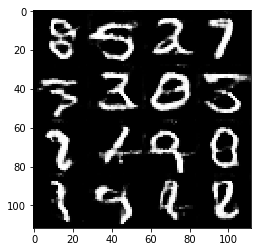

Epoch 2/2... Discriminator Loss: 0.8754... Generator Loss: 0.8966
Epoch 2/2... Discriminator Loss: 1.4680... Generator Loss: 0.3533
Epoch 2/2... Discriminator Loss: 1.5777... Generator Loss: 0.3751
Epoch 2/2... Discriminator Loss: 0.8293... Generator Loss: 1.1863
Epoch 2/2... Discriminator Loss: 0.8105... Generator Loss: 1.1239


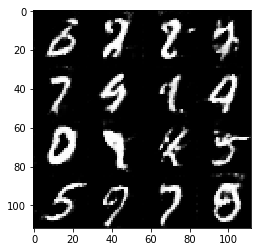

Epoch 2/2... Discriminator Loss: 1.0265... Generator Loss: 0.7784
Epoch 2/2... Discriminator Loss: 1.3728... Generator Loss: 2.0164
Epoch 2/2... Discriminator Loss: 1.4156... Generator Loss: 0.3491
Epoch 2/2... Discriminator Loss: 1.0372... Generator Loss: 0.8583
Epoch 2/2... Discriminator Loss: 0.9898... Generator Loss: 1.0924


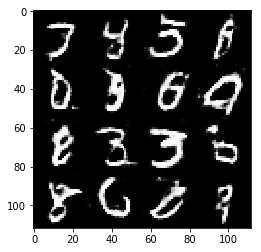

Epoch 2/2... Discriminator Loss: 0.6783... Generator Loss: 1.8030
Epoch 2/2... Discriminator Loss: 0.9773... Generator Loss: 2.9150
Epoch 2/2... Discriminator Loss: 0.5900... Generator Loss: 1.4309
Epoch 2/2... Discriminator Loss: 0.8587... Generator Loss: 1.3022
Epoch 2/2... Discriminator Loss: 1.3074... Generator Loss: 1.1610


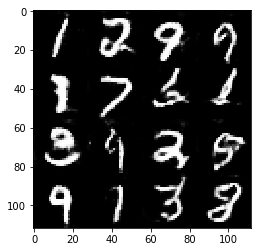

Epoch 2/2... Discriminator Loss: 1.2671... Generator Loss: 0.4773
Epoch 2/2... Discriminator Loss: 0.8910... Generator Loss: 2.5477
Epoch 2/2... Discriminator Loss: 1.6225... Generator Loss: 0.3947
Epoch 2/2... Discriminator Loss: 0.6876... Generator Loss: 1.2309
Epoch 2/2... Discriminator Loss: 1.2260... Generator Loss: 0.5169


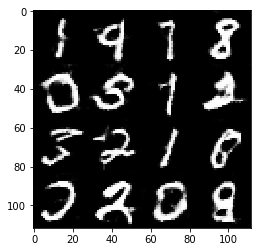

Epoch 2/2... Discriminator Loss: 0.9975... Generator Loss: 0.7003
Epoch 2/2... Discriminator Loss: 2.1194... Generator Loss: 0.1966
Epoch 2/2... Discriminator Loss: 1.1606... Generator Loss: 1.0054
Epoch 2/2... Discriminator Loss: 1.1669... Generator Loss: 0.5021
Epoch 2/2... Discriminator Loss: 0.8886... Generator Loss: 2.1757


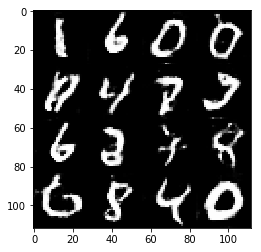

Epoch 2/2... Discriminator Loss: 0.8717... Generator Loss: 0.9140
Epoch 2/2... Discriminator Loss: 0.9459... Generator Loss: 0.6881
Epoch 2/2... Discriminator Loss: 0.6696... Generator Loss: 1.8115
Epoch 2/2... Discriminator Loss: 0.5076... Generator Loss: 2.1326
Epoch 2/2... Discriminator Loss: 0.8856... Generator Loss: 1.0887


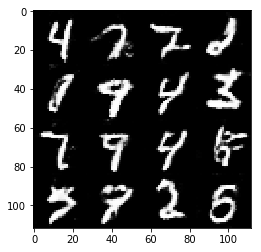

Epoch 2/2... Discriminator Loss: 1.0025... Generator Loss: 1.4656
Epoch 2/2... Discriminator Loss: 1.1607... Generator Loss: 0.4894
Epoch 2/2... Discriminator Loss: 1.2505... Generator Loss: 1.5580
Epoch 2/2... Discriminator Loss: 1.4889... Generator Loss: 0.4251
Epoch 2/2... Discriminator Loss: 0.9484... Generator Loss: 1.4223


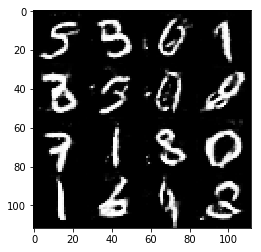

Epoch 2/2... Discriminator Loss: 1.7442... Generator Loss: 0.2762
Epoch 2/2... Discriminator Loss: 0.9887... Generator Loss: 0.6902
Epoch 2/2... Discriminator Loss: 1.1468... Generator Loss: 0.7015
Epoch 2/2... Discriminator Loss: 0.9392... Generator Loss: 0.7717
Epoch 2/2... Discriminator Loss: 0.8847... Generator Loss: 0.9723


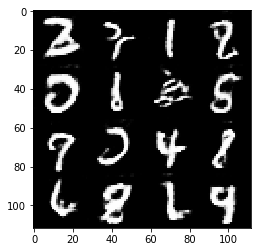

Epoch 2/2... Discriminator Loss: 0.6915... Generator Loss: 1.3974
Epoch 2/2... Discriminator Loss: 0.8741... Generator Loss: 0.8406
Epoch 2/2... Discriminator Loss: 0.8679... Generator Loss: 0.7969
Epoch 2/2... Discriminator Loss: 0.6565... Generator Loss: 1.2990
Epoch 2/2... Discriminator Loss: 1.7008... Generator Loss: 0.2997


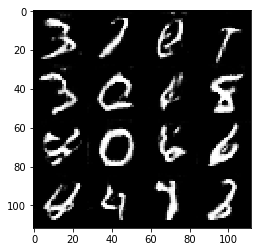

Epoch 2/2... Discriminator Loss: 0.7310... Generator Loss: 1.1459
Epoch 2/2... Discriminator Loss: 0.9770... Generator Loss: 0.7447
Epoch 2/2... Discriminator Loss: 1.9551... Generator Loss: 0.3036
Epoch 2/2... Discriminator Loss: 1.4365... Generator Loss: 3.5783
Epoch 2/2... Discriminator Loss: 0.6980... Generator Loss: 1.1416


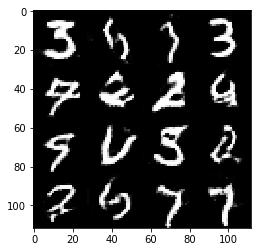

Epoch 2/2... Discriminator Loss: 0.6774... Generator Loss: 1.3180
Epoch 2/2... Discriminator Loss: 1.0912... Generator Loss: 0.7693
Epoch 2/2... Discriminator Loss: 0.8380... Generator Loss: 1.4756
Epoch 2/2... Discriminator Loss: 0.5403... Generator Loss: 1.5496
Epoch 2/2... Discriminator Loss: 1.2582... Generator Loss: 1.1279


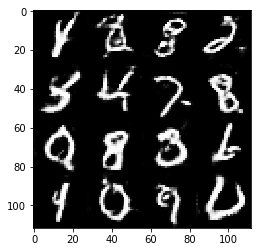

Epoch 2/2... Discriminator Loss: 1.1307... Generator Loss: 1.2449
Epoch 2/2... Discriminator Loss: 1.4167... Generator Loss: 0.4722
Epoch 2/2... Discriminator Loss: 1.7587... Generator Loss: 0.2845
Epoch 2/2... Discriminator Loss: 1.9090... Generator Loss: 0.2284
Epoch 2/2... Discriminator Loss: 1.1556... Generator Loss: 2.5493


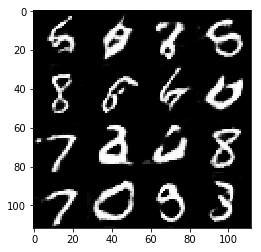

Epoch 2/2... Discriminator Loss: 0.7092... Generator Loss: 1.1555
Epoch 2/2... Discriminator Loss: 0.9458... Generator Loss: 0.7102


In [21]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.3337... Generator Loss: 0.4529
Epoch 1/1... Discriminator Loss: 0.5471... Generator Loss: 1.4892
Epoch 1/1... Discriminator Loss: 0.2193... Generator Loss: 2.8746
Epoch 1/1... Discriminator Loss: 0.0758... Generator Loss: 3.9006
Epoch 1/1... Discriminator Loss: 0.5746... Generator Loss: 1.5347


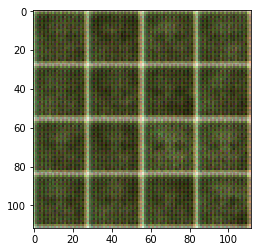

Epoch 1/1... Discriminator Loss: 0.6224... Generator Loss: 1.3197
Epoch 1/1... Discriminator Loss: 0.4523... Generator Loss: 1.8155
Epoch 1/1... Discriminator Loss: 0.7452... Generator Loss: 2.4009
Epoch 1/1... Discriminator Loss: 0.8636... Generator Loss: 5.5220
Epoch 1/1... Discriminator Loss: 0.7070... Generator Loss: 0.9865


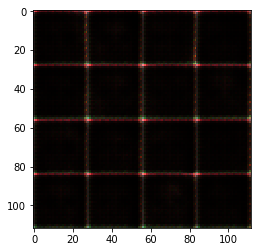

Epoch 1/1... Discriminator Loss: 0.6106... Generator Loss: 0.9767
Epoch 1/1... Discriminator Loss: 1.0875... Generator Loss: 7.5557
Epoch 1/1... Discriminator Loss: 0.4532... Generator Loss: 2.1231
Epoch 1/1... Discriminator Loss: 1.8803... Generator Loss: 6.8023
Epoch 1/1... Discriminator Loss: 0.2212... Generator Loss: 3.9069


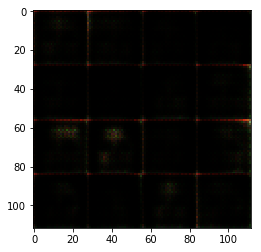

Epoch 1/1... Discriminator Loss: 0.6106... Generator Loss: 4.4855
Epoch 1/1... Discriminator Loss: 2.5158... Generator Loss: 7.2623
Epoch 1/1... Discriminator Loss: 0.3068... Generator Loss: 2.1035
Epoch 1/1... Discriminator Loss: 0.5636... Generator Loss: 1.7225
Epoch 1/1... Discriminator Loss: 0.3937... Generator Loss: 4.2503


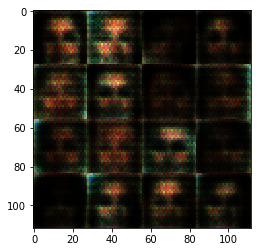

Epoch 1/1... Discriminator Loss: 1.2631... Generator Loss: 3.9679
Epoch 1/1... Discriminator Loss: 0.4752... Generator Loss: 3.0373
Epoch 1/1... Discriminator Loss: 1.7423... Generator Loss: 0.3128
Epoch 1/1... Discriminator Loss: 0.7884... Generator Loss: 0.9136
Epoch 1/1... Discriminator Loss: 0.2319... Generator Loss: 4.0989


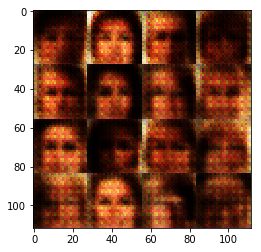

Epoch 1/1... Discriminator Loss: 0.1448... Generator Loss: 4.1719
Epoch 1/1... Discriminator Loss: 0.4277... Generator Loss: 1.8499
Epoch 1/1... Discriminator Loss: 2.0275... Generator Loss: 0.2328
Epoch 1/1... Discriminator Loss: 1.4469... Generator Loss: 0.5418
Epoch 1/1... Discriminator Loss: 0.9716... Generator Loss: 0.7427


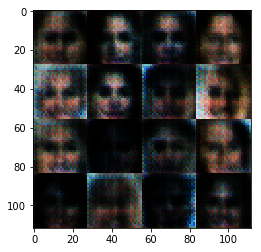

Epoch 1/1... Discriminator Loss: 1.6711... Generator Loss: 0.2899
Epoch 1/1... Discriminator Loss: 0.7021... Generator Loss: 0.9686
Epoch 1/1... Discriminator Loss: 0.2708... Generator Loss: 2.2406
Epoch 1/1... Discriminator Loss: 1.0396... Generator Loss: 0.6136
Epoch 1/1... Discriminator Loss: 1.5564... Generator Loss: 4.8339


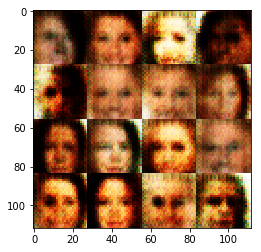

Epoch 1/1... Discriminator Loss: 0.3181... Generator Loss: 3.3241
Epoch 1/1... Discriminator Loss: 2.1129... Generator Loss: 0.1981
Epoch 1/1... Discriminator Loss: 0.5369... Generator Loss: 1.3332
Epoch 1/1... Discriminator Loss: 1.5745... Generator Loss: 5.0047
Epoch 1/1... Discriminator Loss: 0.2963... Generator Loss: 5.4271


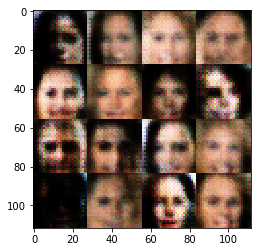

Epoch 1/1... Discriminator Loss: 0.2332... Generator Loss: 2.2908
Epoch 1/1... Discriminator Loss: 0.9872... Generator Loss: 1.0109
Epoch 1/1... Discriminator Loss: 0.2183... Generator Loss: 2.8196
Epoch 1/1... Discriminator Loss: 0.4009... Generator Loss: 4.6642
Epoch 1/1... Discriminator Loss: 1.7319... Generator Loss: 0.2561


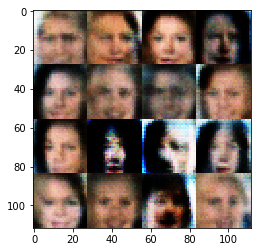

Epoch 1/1... Discriminator Loss: 0.3689... Generator Loss: 2.2068
Epoch 1/1... Discriminator Loss: 1.1003... Generator Loss: 0.5764
Epoch 1/1... Discriminator Loss: 0.4455... Generator Loss: 1.7748
Epoch 1/1... Discriminator Loss: 0.8569... Generator Loss: 0.7746
Epoch 1/1... Discriminator Loss: 0.2503... Generator Loss: 3.7970


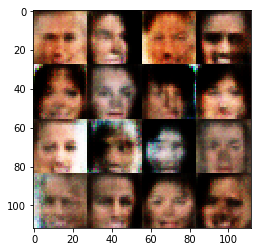

Epoch 1/1... Discriminator Loss: 2.1533... Generator Loss: 0.1485
Epoch 1/1... Discriminator Loss: 0.8555... Generator Loss: 0.7437
Epoch 1/1... Discriminator Loss: 1.6495... Generator Loss: 0.2782
Epoch 1/1... Discriminator Loss: 2.2426... Generator Loss: 0.1726
Epoch 1/1... Discriminator Loss: 0.3428... Generator Loss: 3.7944


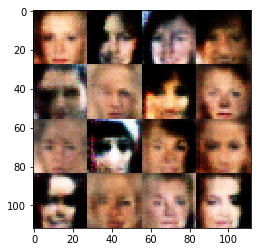

Epoch 1/1... Discriminator Loss: 0.1985... Generator Loss: 4.9963
Epoch 1/1... Discriminator Loss: 0.2375... Generator Loss: 2.9088
Epoch 1/1... Discriminator Loss: 0.2094... Generator Loss: 2.1968
Epoch 1/1... Discriminator Loss: 4.1685... Generator Loss: 3.9650
Epoch 1/1... Discriminator Loss: 0.4480... Generator Loss: 1.7734


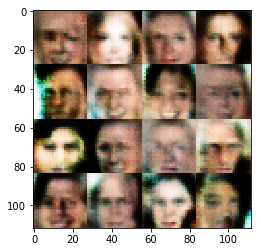

Epoch 1/1... Discriminator Loss: 0.7818... Generator Loss: 0.8217
Epoch 1/1... Discriminator Loss: 0.5399... Generator Loss: 1.1966
Epoch 1/1... Discriminator Loss: 0.5241... Generator Loss: 2.0480
Epoch 1/1... Discriminator Loss: 0.5532... Generator Loss: 1.3199
Epoch 1/1... Discriminator Loss: 0.6674... Generator Loss: 1.2677


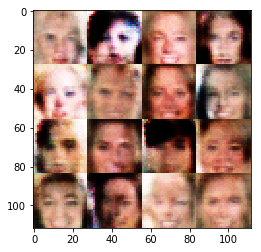

Epoch 1/1... Discriminator Loss: 1.0134... Generator Loss: 0.6230
Epoch 1/1... Discriminator Loss: 0.2562... Generator Loss: 2.2456
Epoch 1/1... Discriminator Loss: 0.6054... Generator Loss: 2.9064
Epoch 1/1... Discriminator Loss: 0.5754... Generator Loss: 1.0998
Epoch 1/1... Discriminator Loss: 0.6290... Generator Loss: 6.4933


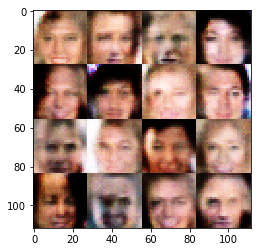

Epoch 1/1... Discriminator Loss: 0.3679... Generator Loss: 1.6825
Epoch 1/1... Discriminator Loss: 0.1995... Generator Loss: 2.4744
Epoch 1/1... Discriminator Loss: 0.8053... Generator Loss: 0.8528
Epoch 1/1... Discriminator Loss: 0.3380... Generator Loss: 1.8995
Epoch 1/1... Discriminator Loss: 0.6824... Generator Loss: 3.9667


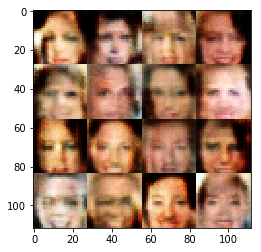

Epoch 1/1... Discriminator Loss: 0.2859... Generator Loss: 1.9543
Epoch 1/1... Discriminator Loss: 0.4183... Generator Loss: 3.0743
Epoch 1/1... Discriminator Loss: 0.2487... Generator Loss: 1.9909
Epoch 1/1... Discriminator Loss: 0.7908... Generator Loss: 0.7908
Epoch 1/1... Discriminator Loss: 0.4112... Generator Loss: 1.5936


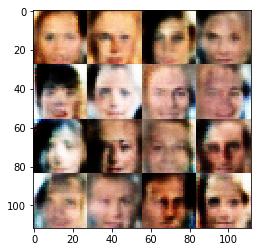

Epoch 1/1... Discriminator Loss: 1.8002... Generator Loss: 3.0798
Epoch 1/1... Discriminator Loss: 0.3201... Generator Loss: 2.8273
Epoch 1/1... Discriminator Loss: 0.2552... Generator Loss: 2.2221
Epoch 1/1... Discriminator Loss: 0.3027... Generator Loss: 4.3104
Epoch 1/1... Discriminator Loss: 0.2552... Generator Loss: 2.4768


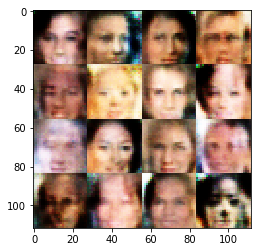

Epoch 1/1... Discriminator Loss: 0.1447... Generator Loss: 3.6447
Epoch 1/1... Discriminator Loss: 0.1984... Generator Loss: 3.3435
Epoch 1/1... Discriminator Loss: 0.2718... Generator Loss: 2.6367
Epoch 1/1... Discriminator Loss: 0.3685... Generator Loss: 2.3308
Epoch 1/1... Discriminator Loss: 1.6132... Generator Loss: 0.3557


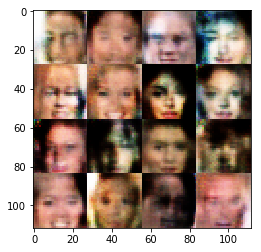

Epoch 1/1... Discriminator Loss: 0.3701... Generator Loss: 1.7382
Epoch 1/1... Discriminator Loss: 0.7003... Generator Loss: 1.2281
Epoch 1/1... Discriminator Loss: 0.3747... Generator Loss: 1.7766
Epoch 1/1... Discriminator Loss: 1.4278... Generator Loss: 4.0861
Epoch 1/1... Discriminator Loss: 0.9095... Generator Loss: 0.6834


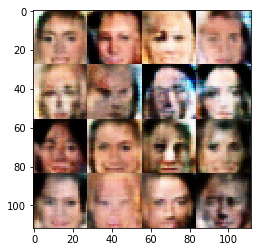

Epoch 1/1... Discriminator Loss: 0.8395... Generator Loss: 2.1137
Epoch 1/1... Discriminator Loss: 0.1785... Generator Loss: 4.7471
Epoch 1/1... Discriminator Loss: 0.2745... Generator Loss: 2.2966
Epoch 1/1... Discriminator Loss: 1.9525... Generator Loss: 0.2377
Epoch 1/1... Discriminator Loss: 0.2742... Generator Loss: 2.8131


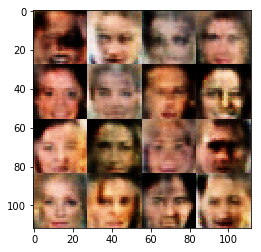

Epoch 1/1... Discriminator Loss: 1.8821... Generator Loss: 0.2100
Epoch 1/1... Discriminator Loss: 0.3457... Generator Loss: 2.2775
Epoch 1/1... Discriminator Loss: 1.0630... Generator Loss: 0.6063
Epoch 1/1... Discriminator Loss: 0.1355... Generator Loss: 4.4695
Epoch 1/1... Discriminator Loss: 0.2484... Generator Loss: 4.8222


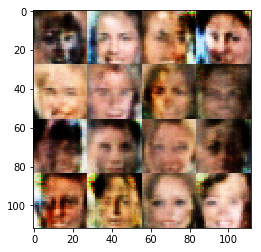

Epoch 1/1... Discriminator Loss: 0.6770... Generator Loss: 1.1221
Epoch 1/1... Discriminator Loss: 0.3293... Generator Loss: 2.7907
Epoch 1/1... Discriminator Loss: 0.1440... Generator Loss: 4.4850
Epoch 1/1... Discriminator Loss: 0.5530... Generator Loss: 1.1916
Epoch 1/1... Discriminator Loss: 0.2456... Generator Loss: 3.5216


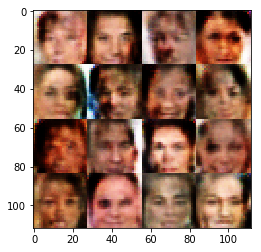

Epoch 1/1... Discriminator Loss: 1.2633... Generator Loss: 0.4191
Epoch 1/1... Discriminator Loss: 0.2986... Generator Loss: 6.9550
Epoch 1/1... Discriminator Loss: 0.1803... Generator Loss: 2.4233
Epoch 1/1... Discriminator Loss: 1.3054... Generator Loss: 0.3957
Epoch 1/1... Discriminator Loss: 0.4832... Generator Loss: 1.7014


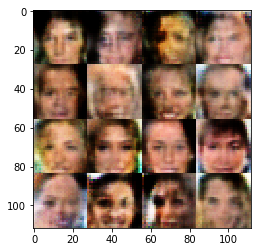

Epoch 1/1... Discriminator Loss: 0.1841... Generator Loss: 2.9640
Epoch 1/1... Discriminator Loss: 0.3378... Generator Loss: 2.1250
Epoch 1/1... Discriminator Loss: 0.3092... Generator Loss: 2.3264
Epoch 1/1... Discriminator Loss: 0.3592... Generator Loss: 2.1834
Epoch 1/1... Discriminator Loss: 0.3751... Generator Loss: 1.6819


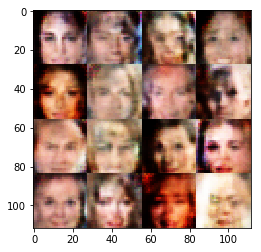

Epoch 1/1... Discriminator Loss: 0.2165... Generator Loss: 5.8806
Epoch 1/1... Discriminator Loss: 0.5826... Generator Loss: 1.2013
Epoch 1/1... Discriminator Loss: 1.7168... Generator Loss: 0.2676
Epoch 1/1... Discriminator Loss: 0.2783... Generator Loss: 2.1917
Epoch 1/1... Discriminator Loss: 0.1406... Generator Loss: 3.7868


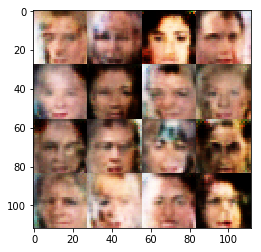

Epoch 1/1... Discriminator Loss: 1.9785... Generator Loss: 0.2531
Epoch 1/1... Discriminator Loss: 0.4666... Generator Loss: 2.9887
Epoch 1/1... Discriminator Loss: 0.2176... Generator Loss: 3.1851
Epoch 1/1... Discriminator Loss: 0.6224... Generator Loss: 1.3376
Epoch 1/1... Discriminator Loss: 0.5860... Generator Loss: 2.1517


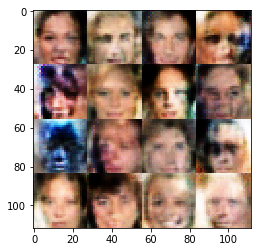

Epoch 1/1... Discriminator Loss: 0.5283... Generator Loss: 1.2753
Epoch 1/1... Discriminator Loss: 0.5191... Generator Loss: 6.5658
Epoch 1/1... Discriminator Loss: 0.0922... Generator Loss: 4.0042
Epoch 1/1... Discriminator Loss: 0.3436... Generator Loss: 1.7359
Epoch 1/1... Discriminator Loss: 0.0734... Generator Loss: 6.8361


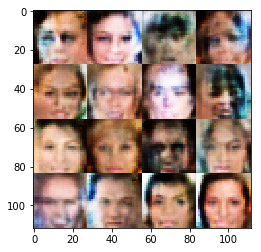

Epoch 1/1... Discriminator Loss: 0.3266... Generator Loss: 1.7995
Epoch 1/1... Discriminator Loss: 0.2214... Generator Loss: 2.3226
Epoch 1/1... Discriminator Loss: 0.6003... Generator Loss: 0.9771
Epoch 1/1... Discriminator Loss: 0.3496... Generator Loss: 2.4139
Epoch 1/1... Discriminator Loss: 0.3840... Generator Loss: 2.8521


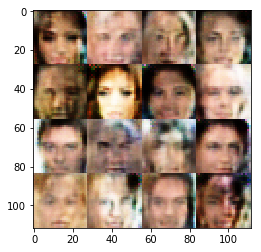

Epoch 1/1... Discriminator Loss: 0.2896... Generator Loss: 1.9615
Epoch 1/1... Discriminator Loss: 0.5075... Generator Loss: 1.4437
Epoch 1/1... Discriminator Loss: 0.5825... Generator Loss: 1.1735
Epoch 1/1... Discriminator Loss: 0.2942... Generator Loss: 2.0231
Epoch 1/1... Discriminator Loss: 0.1337... Generator Loss: 3.0545


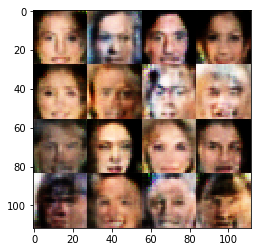

Epoch 1/1... Discriminator Loss: 0.2377... Generator Loss: 2.4784
Epoch 1/1... Discriminator Loss: 1.5261... Generator Loss: 5.5682
Epoch 1/1... Discriminator Loss: 0.5786... Generator Loss: 1.1151
Epoch 1/1... Discriminator Loss: 0.4480... Generator Loss: 1.6157
Epoch 1/1... Discriminator Loss: 0.2844... Generator Loss: 2.0047


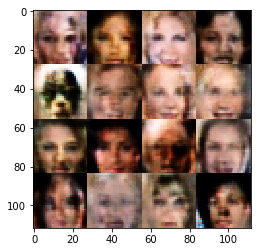

Epoch 1/1... Discriminator Loss: 0.5600... Generator Loss: 3.6077
Epoch 1/1... Discriminator Loss: 0.8036... Generator Loss: 0.8106
Epoch 1/1... Discriminator Loss: 0.0625... Generator Loss: 6.5256
Epoch 1/1... Discriminator Loss: 0.2158... Generator Loss: 2.3658
Epoch 1/1... Discriminator Loss: 0.4135... Generator Loss: 1.5974


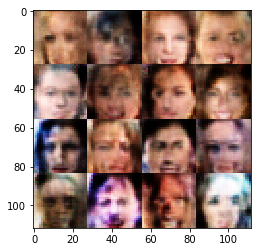

Epoch 1/1... Discriminator Loss: 1.8835... Generator Loss: 5.9950
Epoch 1/1... Discriminator Loss: 1.4483... Generator Loss: 2.9317
Epoch 1/1... Discriminator Loss: 0.5461... Generator Loss: 2.4576
Epoch 1/1... Discriminator Loss: 0.4411... Generator Loss: 1.4024
Epoch 1/1... Discriminator Loss: 1.0332... Generator Loss: 2.3147


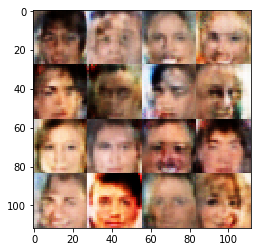

Epoch 1/1... Discriminator Loss: 0.8319... Generator Loss: 3.2921
Epoch 1/1... Discriminator Loss: 0.4313... Generator Loss: 1.8639
Epoch 1/1... Discriminator Loss: 0.0552... Generator Loss: 6.1455
Epoch 1/1... Discriminator Loss: 0.1390... Generator Loss: 2.9603
Epoch 1/1... Discriminator Loss: 0.1098... Generator Loss: 5.5197


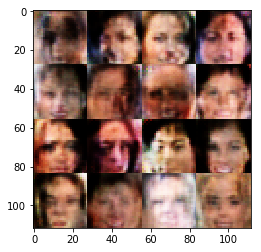

Epoch 1/1... Discriminator Loss: 3.3249... Generator Loss: 0.0893
Epoch 1/1... Discriminator Loss: 0.5224... Generator Loss: 1.5772
Epoch 1/1... Discriminator Loss: 0.7391... Generator Loss: 0.9029
Epoch 1/1... Discriminator Loss: 0.5100... Generator Loss: 1.3863
Epoch 1/1... Discriminator Loss: 0.0902... Generator Loss: 5.9772


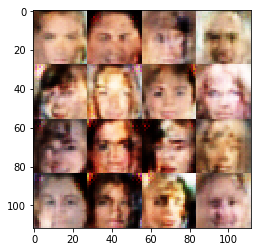

Epoch 1/1... Discriminator Loss: 0.4674... Generator Loss: 1.3213
Epoch 1/1... Discriminator Loss: 0.4856... Generator Loss: 2.1381
Epoch 1/1... Discriminator Loss: 0.2023... Generator Loss: 2.4711
Epoch 1/1... Discriminator Loss: 0.2529... Generator Loss: 2.1492
Epoch 1/1... Discriminator Loss: 0.2096... Generator Loss: 2.4369


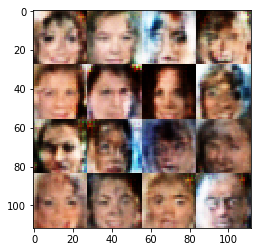

Epoch 1/1... Discriminator Loss: 2.4075... Generator Loss: 0.1324
Epoch 1/1... Discriminator Loss: 0.1322... Generator Loss: 3.1047
Epoch 1/1... Discriminator Loss: 0.6581... Generator Loss: 1.0765
Epoch 1/1... Discriminator Loss: 0.3341... Generator Loss: 2.0581
Epoch 1/1... Discriminator Loss: 0.2717... Generator Loss: 2.1148


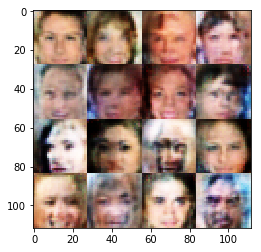

Epoch 1/1... Discriminator Loss: 0.3925... Generator Loss: 1.6804
Epoch 1/1... Discriminator Loss: 0.2986... Generator Loss: 1.7135
Epoch 1/1... Discriminator Loss: 0.6152... Generator Loss: 4.3952
Epoch 1/1... Discriminator Loss: 0.1697... Generator Loss: 2.6881
Epoch 1/1... Discriminator Loss: 0.3799... Generator Loss: 2.1562


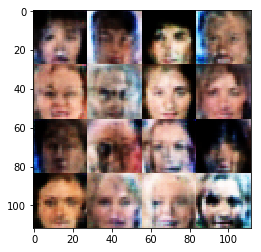

Epoch 1/1... Discriminator Loss: 0.3771... Generator Loss: 1.5644
Epoch 1/1... Discriminator Loss: 0.3567... Generator Loss: 1.9153
Epoch 1/1... Discriminator Loss: 3.0737... Generator Loss: 0.1032
Epoch 1/1... Discriminator Loss: 0.2709... Generator Loss: 2.3225
Epoch 1/1... Discriminator Loss: 0.6571... Generator Loss: 4.3484


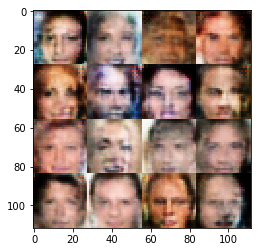

Epoch 1/1... Discriminator Loss: 0.5230... Generator Loss: 1.1856
Epoch 1/1... Discriminator Loss: 0.2967... Generator Loss: 1.8200
Epoch 1/1... Discriminator Loss: 1.2156... Generator Loss: 0.4735
Epoch 1/1... Discriminator Loss: 0.6539... Generator Loss: 0.9498
Epoch 1/1... Discriminator Loss: 0.3797... Generator Loss: 1.6799


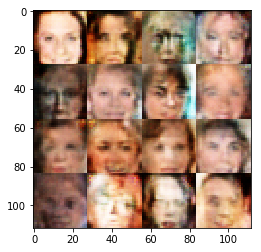

Epoch 1/1... Discriminator Loss: 0.6075... Generator Loss: 1.2103
Epoch 1/1... Discriminator Loss: 0.9313... Generator Loss: 3.5015
Epoch 1/1... Discriminator Loss: 0.2095... Generator Loss: 4.8503
Epoch 1/1... Discriminator Loss: 0.7113... Generator Loss: 2.2151
Epoch 1/1... Discriminator Loss: 1.1438... Generator Loss: 0.5155


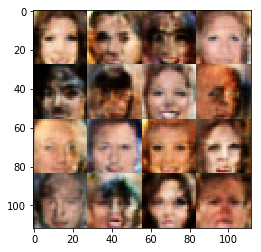

Epoch 1/1... Discriminator Loss: 0.0634... Generator Loss: 4.7707
Epoch 1/1... Discriminator Loss: 0.2991... Generator Loss: 1.9826
Epoch 1/1... Discriminator Loss: 0.2115... Generator Loss: 2.1571
Epoch 1/1... Discriminator Loss: 0.4362... Generator Loss: 4.3117
Epoch 1/1... Discriminator Loss: 0.3661... Generator Loss: 2.4404


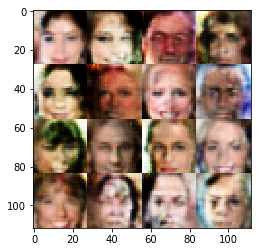

Epoch 1/1... Discriminator Loss: 0.6432... Generator Loss: 0.9322
Epoch 1/1... Discriminator Loss: 0.1317... Generator Loss: 2.9862
Epoch 1/1... Discriminator Loss: 0.4624... Generator Loss: 1.3623
Epoch 1/1... Discriminator Loss: 1.1664... Generator Loss: 0.7036
Epoch 1/1... Discriminator Loss: 0.7652... Generator Loss: 1.9391


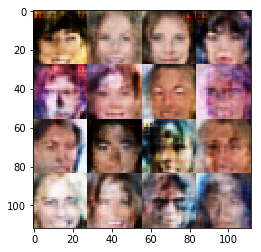

Epoch 1/1... Discriminator Loss: 0.4954... Generator Loss: 1.8542
Epoch 1/1... Discriminator Loss: 0.1694... Generator Loss: 2.4861
Epoch 1/1... Discriminator Loss: 0.1566... Generator Loss: 3.3292
Epoch 1/1... Discriminator Loss: 0.0989... Generator Loss: 3.7405
Epoch 1/1... Discriminator Loss: 0.3173... Generator Loss: 2.0110


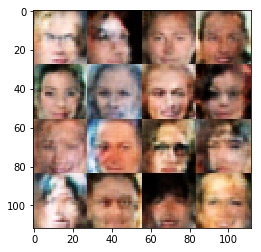

Epoch 1/1... Discriminator Loss: 0.4480... Generator Loss: 1.3958
Epoch 1/1... Discriminator Loss: 0.3170... Generator Loss: 1.8775
Epoch 1/1... Discriminator Loss: 0.2913... Generator Loss: 1.9590
Epoch 1/1... Discriminator Loss: 0.3642... Generator Loss: 1.7251
Epoch 1/1... Discriminator Loss: 0.1340... Generator Loss: 4.0507


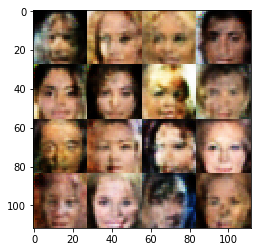

Epoch 1/1... Discriminator Loss: 0.3506... Generator Loss: 2.5267
Epoch 1/1... Discriminator Loss: 0.3170... Generator Loss: 5.7280
Epoch 1/1... Discriminator Loss: 0.5612... Generator Loss: 1.1909
Epoch 1/1... Discriminator Loss: 1.6433... Generator Loss: 2.0814
Epoch 1/1... Discriminator Loss: 0.3809... Generator Loss: 1.6852


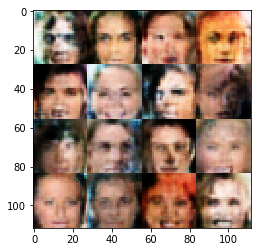

Epoch 1/1... Discriminator Loss: 0.2566... Generator Loss: 2.2523
Epoch 1/1... Discriminator Loss: 0.8750... Generator Loss: 0.7380
Epoch 1/1... Discriminator Loss: 0.5440... Generator Loss: 1.3151
Epoch 1/1... Discriminator Loss: 0.9989... Generator Loss: 5.7747
Epoch 1/1... Discriminator Loss: 1.2387... Generator Loss: 2.9639


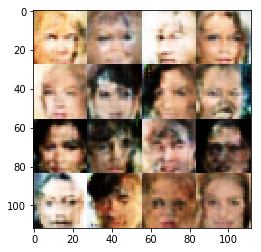

Epoch 1/1... Discriminator Loss: 0.2708... Generator Loss: 2.8097
Epoch 1/1... Discriminator Loss: 0.2284... Generator Loss: 2.8773
Epoch 1/1... Discriminator Loss: 0.3133... Generator Loss: 1.9859
Epoch 1/1... Discriminator Loss: 0.3440... Generator Loss: 4.0258
Epoch 1/1... Discriminator Loss: 0.1822... Generator Loss: 3.7645


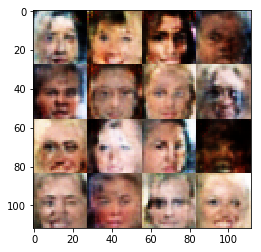

Epoch 1/1... Discriminator Loss: 0.8340... Generator Loss: 1.2233
Epoch 1/1... Discriminator Loss: 0.2469... Generator Loss: 1.9506
Epoch 1/1... Discriminator Loss: 1.0416... Generator Loss: 0.7548
Epoch 1/1... Discriminator Loss: 0.3526... Generator Loss: 1.6572
Epoch 1/1... Discriminator Loss: 0.1962... Generator Loss: 2.2214


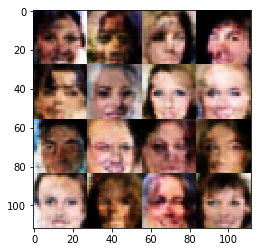

Epoch 1/1... Discriminator Loss: 0.8660... Generator Loss: 0.7987
Epoch 1/1... Discriminator Loss: 0.1626... Generator Loss: 2.5768
Epoch 1/1... Discriminator Loss: 0.2763... Generator Loss: 2.3431
Epoch 1/1... Discriminator Loss: 0.1457... Generator Loss: 3.3070
Epoch 1/1... Discriminator Loss: 0.3450... Generator Loss: 2.0634


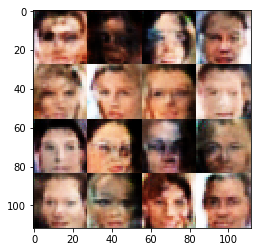

Epoch 1/1... Discriminator Loss: 0.2867... Generator Loss: 2.2728
Epoch 1/1... Discriminator Loss: 0.3021... Generator Loss: 1.9199
Epoch 1/1... Discriminator Loss: 0.1405... Generator Loss: 3.2091
Epoch 1/1... Discriminator Loss: 0.2029... Generator Loss: 4.9388
Epoch 1/1... Discriminator Loss: 0.1527... Generator Loss: 4.2228


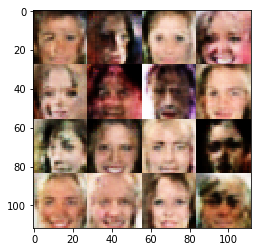

Epoch 1/1... Discriminator Loss: 0.5349... Generator Loss: 1.3371
Epoch 1/1... Discriminator Loss: 0.4054... Generator Loss: 1.6878
Epoch 1/1... Discriminator Loss: 0.6799... Generator Loss: 1.0524
Epoch 1/1... Discriminator Loss: 0.2929... Generator Loss: 2.0703
Epoch 1/1... Discriminator Loss: 1.8195... Generator Loss: 0.2824


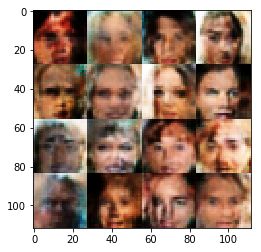

Epoch 1/1... Discriminator Loss: 1.1521... Generator Loss: 0.6181
Epoch 1/1... Discriminator Loss: 0.7440... Generator Loss: 1.0436
Epoch 1/1... Discriminator Loss: 0.0538... Generator Loss: 4.2337
Epoch 1/1... Discriminator Loss: 0.4917... Generator Loss: 1.6483
Epoch 1/1... Discriminator Loss: 1.6466... Generator Loss: 0.2914


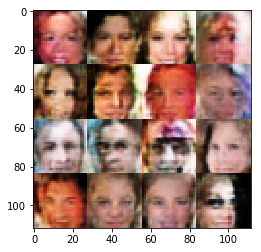

Epoch 1/1... Discriminator Loss: 0.0992... Generator Loss: 3.5385
Epoch 1/1... Discriminator Loss: 0.5925... Generator Loss: 1.1136
Epoch 1/1... Discriminator Loss: 0.1563... Generator Loss: 3.5802
Epoch 1/1... Discriminator Loss: 0.2677... Generator Loss: 1.9187
Epoch 1/1... Discriminator Loss: 0.4356... Generator Loss: 3.8980


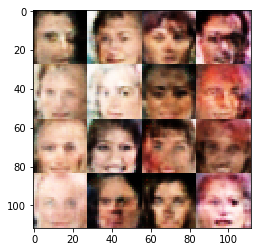

Epoch 1/1... Discriminator Loss: 0.7521... Generator Loss: 3.5562
Epoch 1/1... Discriminator Loss: 0.7498... Generator Loss: 0.9173
Epoch 1/1... Discriminator Loss: 0.9680... Generator Loss: 2.8279
Epoch 1/1... Discriminator Loss: 1.9526... Generator Loss: 0.2186
Epoch 1/1... Discriminator Loss: 0.1043... Generator Loss: 3.5388


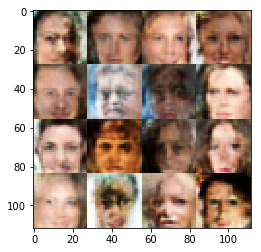

Epoch 1/1... Discriminator Loss: 0.2762... Generator Loss: 2.5379
Epoch 1/1... Discriminator Loss: 1.4851... Generator Loss: 0.3928
Epoch 1/1... Discriminator Loss: 0.4931... Generator Loss: 1.5039
Epoch 1/1... Discriminator Loss: 0.2532... Generator Loss: 4.2915
Epoch 1/1... Discriminator Loss: 0.1493... Generator Loss: 3.0858


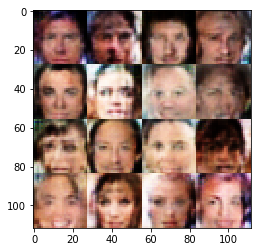

Epoch 1/1... Discriminator Loss: 0.8892... Generator Loss: 1.4887
Epoch 1/1... Discriminator Loss: 0.2343... Generator Loss: 2.2827
Epoch 1/1... Discriminator Loss: 0.2524... Generator Loss: 2.0555
Epoch 1/1... Discriminator Loss: 0.2502... Generator Loss: 7.9174
Epoch 1/1... Discriminator Loss: 1.7649... Generator Loss: 0.2108


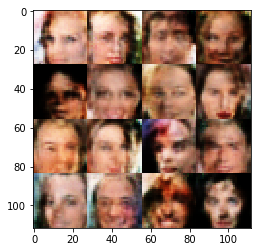

Epoch 1/1... Discriminator Loss: 0.7113... Generator Loss: 0.8948
Epoch 1/1... Discriminator Loss: 0.1757... Generator Loss: 4.7996
Epoch 1/1... Discriminator Loss: 0.1098... Generator Loss: 6.0719
Epoch 1/1... Discriminator Loss: 0.1927... Generator Loss: 3.4625
Epoch 1/1... Discriminator Loss: 0.5899... Generator Loss: 3.8673


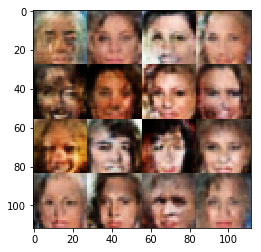

Epoch 1/1... Discriminator Loss: 0.1937... Generator Loss: 4.7028
Epoch 1/1... Discriminator Loss: 0.3588... Generator Loss: 3.0946
Epoch 1/1... Discriminator Loss: 0.1799... Generator Loss: 3.3371
Epoch 1/1... Discriminator Loss: 0.5868... Generator Loss: 3.7204
Epoch 1/1... Discriminator Loss: 2.0056... Generator Loss: 6.4126


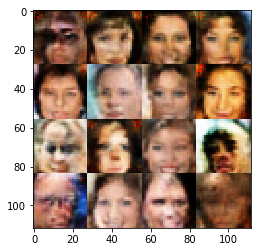

Epoch 1/1... Discriminator Loss: 0.6662... Generator Loss: 1.1080
Epoch 1/1... Discriminator Loss: 0.5422... Generator Loss: 1.5635
Epoch 1/1... Discriminator Loss: 0.8601... Generator Loss: 0.8378
Epoch 1/1... Discriminator Loss: 0.3836... Generator Loss: 1.6961
Epoch 1/1... Discriminator Loss: 0.2935... Generator Loss: 2.2005


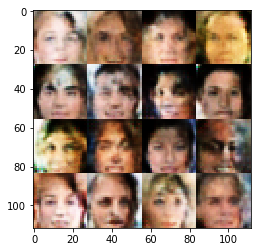

Epoch 1/1... Discriminator Loss: 0.3542... Generator Loss: 5.3223
Epoch 1/1... Discriminator Loss: 0.3275... Generator Loss: 4.3413
Epoch 1/1... Discriminator Loss: 0.2784... Generator Loss: 2.4348
Epoch 1/1... Discriminator Loss: 0.4806... Generator Loss: 1.2943
Epoch 1/1... Discriminator Loss: 0.3732... Generator Loss: 1.6471


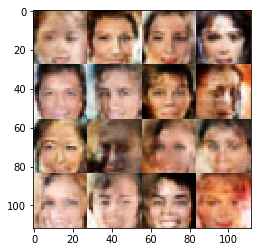

Epoch 1/1... Discriminator Loss: 0.3623... Generator Loss: 2.1193
Epoch 1/1... Discriminator Loss: 0.3034... Generator Loss: 3.0420
Epoch 1/1... Discriminator Loss: 0.1714... Generator Loss: 7.2406
Epoch 1/1... Discriminator Loss: 0.2814... Generator Loss: 1.9377
Epoch 1/1... Discriminator Loss: 0.5287... Generator Loss: 1.1916


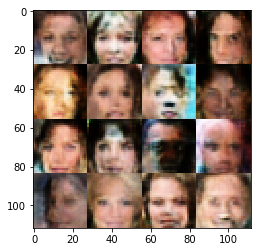

Epoch 1/1... Discriminator Loss: 0.7452... Generator Loss: 0.9752
Epoch 1/1... Discriminator Loss: 0.4383... Generator Loss: 2.0430
Epoch 1/1... Discriminator Loss: 0.1899... Generator Loss: 5.1054
Epoch 1/1... Discriminator Loss: 0.1342... Generator Loss: 4.2253
Epoch 1/1... Discriminator Loss: 0.9694... Generator Loss: 0.6298


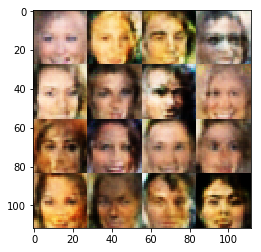

Epoch 1/1... Discriminator Loss: 0.5570... Generator Loss: 1.1528
Epoch 1/1... Discriminator Loss: 0.6496... Generator Loss: 0.9636
Epoch 1/1... Discriminator Loss: 0.1234... Generator Loss: 4.4097
Epoch 1/1... Discriminator Loss: 0.1855... Generator Loss: 3.0110
Epoch 1/1... Discriminator Loss: 1.4008... Generator Loss: 0.3836


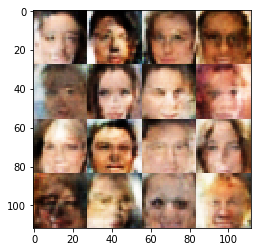

Epoch 1/1... Discriminator Loss: 0.5984... Generator Loss: 1.3531


In [22]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.